In [1]:
!date

Thu Nov 12 10:56:01 PST 2020


# Saturation curves

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set(**{
        "aspect": "equal",
        "xlim": lims,
        "ylim": lims
    })
    return ax

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
gene = anndata.read_h5ad("../../data/notebook/revision/10xv3_gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/10xv3_unique_isoforms.h5ad")

In [3]:
gene

AnnData object with n_obs × n_vars = 94162 × 31053
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name', 'gene_id', 'gene_short_name'

In [4]:
isoform

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


AnnData object with n_obs × n_vars = 169200 × 111079
    obs: 'batch'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov'

In [5]:
isoform.X[0].todense().sum()

6569.0

In [6]:
gene.X[0].todense().sum()

10434.0

In [7]:
iso_umi_counts = nd(isoform.X.sum(axis=1))
gen_umi_counts = nd(gene.X.sum(axis=1))

In [8]:
iso_det = nd((isoform.X > 0).sum(axis=1))
gen_det = nd((gene.X > 0).sum(axis=1))

In [9]:
iso_det.shape

(169200,)

In [10]:
gen_det.shape

(94162,)

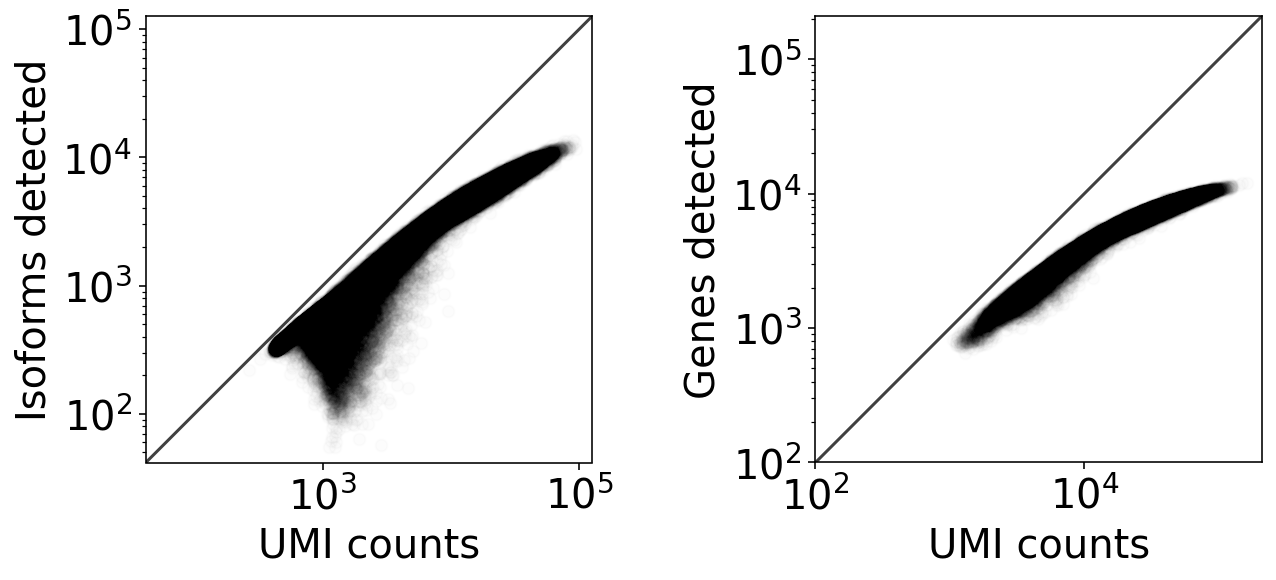

In [11]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

alpha = 0.01

loc = ax[0]
x = iso_umi_counts
y = iso_det
loc.scatter(x, y, color="k", label="Isoform", alpha=alpha)
loc.set(**{
    "xlabel": "UMI counts",
    "ylabel": "Isoforms detected",
    "xscale": "log",
    "yscale": "log",
    "xlim": 100,
})
yex(loc)


loc = ax[1]
x = gen_umi_counts
y = gen_det
loc.scatter(x, y, color="k", label="Gene", alpha=alpha)
loc.set(**{
    "xlabel": "UMI counts",
    "ylabel": "Genes detected",
    "xscale": "log",
    "yscale": "log",
    "xlim": 100,
})
yex(loc)

plt.savefig(trackfig("../../figures/10x_saturation_curves.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)

fig.show()

In [12]:
t = np.linspace(0, 1, 1000)

In [13]:
det_isoforms = nd((isoform.X > 0).sum(axis=0))

hist = pd.Series(det_isoforms).value_counts().values

alt = nd([(-1)**(i+1) for i in range(len(hist))])

U_iso = []
for tt in t:
    tmp_alt = nd([(-tt)**(i+1) for i in range(len(hist))])
    U_iso.append(float(-1*(hist*tmp_alt).sum()))

In [14]:
det_gene = nd((gene.X > 0).sum(axis=0))

hist = pd.Series(det_gene).value_counts().values

alt = nd([(-1)**(i+1) for i in range(len(hist))])

U_gen = []
for tt in t:
    tmp_alt = nd([(-tt)**(i+1) for i in range(len(hist))])
    U_gen.append(float(-1*(hist*tmp_alt).sum()))

In [15]:
n_iso = isoform.shape[1]
n_gen = gene.shape[1]

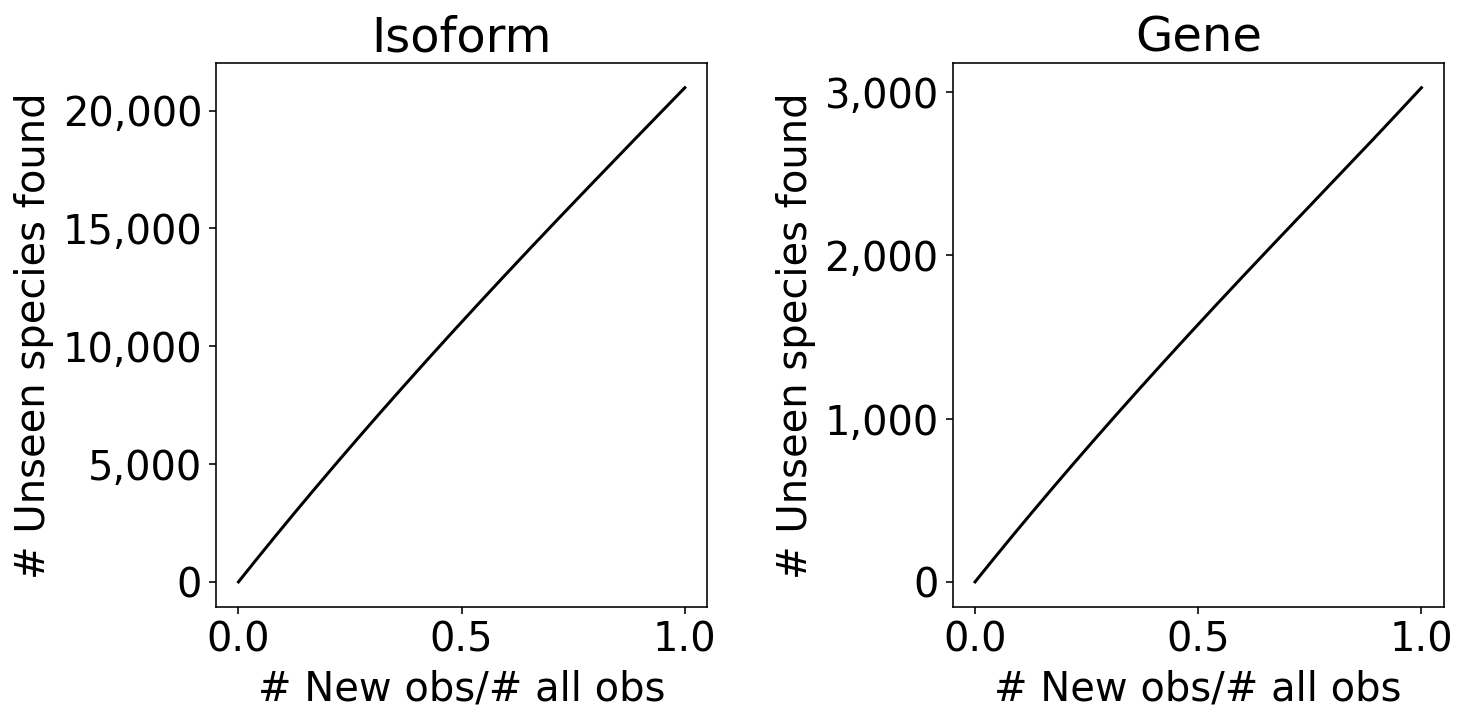

In [16]:
fig, loc = plt.subplots(figsize=(11,5), ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.5)


ax = loc[0]

x = t
y = U_iso

ax.plot(x, y, color="k")

ax.set(**{
    "xlabel": "# New obs/# all obs",
    "ylabel": "# Unseen species found",
    "title": "Isoform",
})

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax = loc[1]

x = t
y = U_gen

ax.plot(x, y, color="k")
ax.set(**{
    "xlabel": "# New obs/# all obs",
    "ylabel": "# Unseen species found",
    "title": "Gene"
})

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


fig.show()

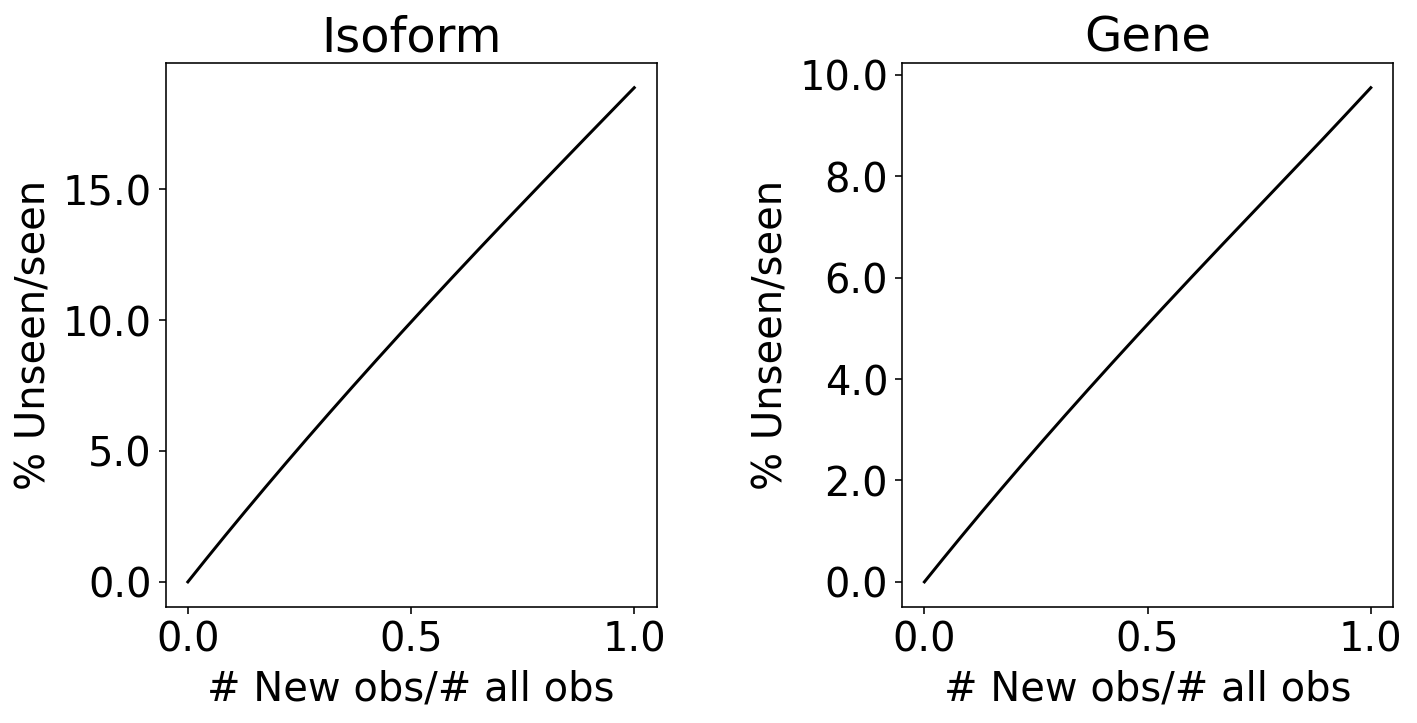

In [17]:
fig, loc = plt.subplots(figsize=(11,5), ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.5)


ax = loc[0]

x = t
y = nd(U_iso)/n_iso*100

ax.plot(x, y, color="k")

ax.set(**{
    "xlabel": "# New obs/# all obs",
    "ylabel": "% Unseen/seen",
    "title": "Isoform",
})

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))

ax = loc[1]

x = t
y = nd(U_gen)/n_gen*100

ax.plot(x, y, color="k")
ax.set(**{
    "xlabel": "# New obs/# all obs",
    "ylabel": "% Unseen/seen",
    "title": "Gene"
})

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))


fig.show()

In [18]:
U_iso[-1]

20971.0

In [19]:
U_gen[-1]

3027.0